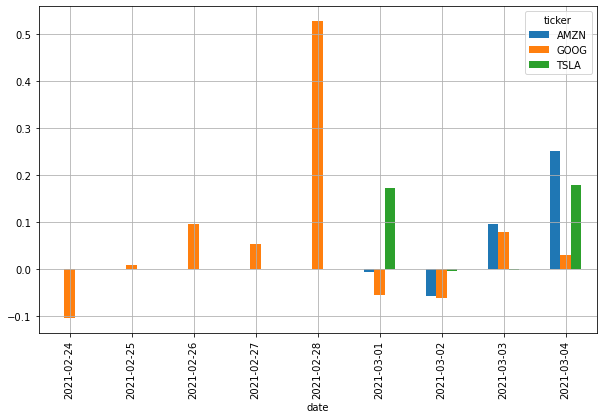

In [2]:
# Import libraries
import urllib.request
%matplotlib inline 
import matplotlib as matplotlib
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt

# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = urllib.request.Request(url=url,headers={'user-agent': 'my-app/0.0.1'})
    response = urllib.request.urlopen(req)
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response,features="html.parser")
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

# # Read one single day of headlines for 'AMZN'
# amzn = news_tables['AMZN']
# # Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
# amzn_tr = amzn.findAll('tr')
#
# for i, table_row in enumerate(amzn_tr):
#     # Read the text of the element 'a' into 'link_text'
#     a_text = table_row.a.text
#     # Read the text of the element 'td' into 'data_text'
#     td_text = table_row.td.text
#     # Print the contents of 'link_text' and 'data_text'
#     print(a_text)
#     print(td_text)
#     # Exit after printing 4 rows of data
#     if i == 10:
#         break

parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text()
        # splite text in the td tag into a list
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]

        # else load 'date' as the 1st element and 'time' as the second
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'
        ticker = file_name.split('_')[0]

        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

parsed_news

# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

# Plotting

plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()
